Create an input file, read or generate the corresponding netcdf simulation file in our database and create a simple plot

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import subprocess # to capture errors from the simulations


First let us inspect the database class for an overview of how it works

In [2]:
help(simplesim)

Help on module simplesimdb:

NAME
    simplesimdb - Creation and management of simple simulation data

CLASSES
    builtins.object
        Manager
        Repeater
    
    class Manager(builtins.object)
     |  Manager(directory='./data', filetype='nc', executable='./execute.sh')
     |  
     |  Lightweight Simulation Database Manager
     |  
     |  Create, access and display simulation data of a given code as pairs
     |  (inputfile.json : outputfile [, restarted_01, restarted_02, ...]),
     |  where all input files are json files (converted from python dictionaries)
     |  and the output files (of arbitrary type) are generated by an executable
     |  that takes the json file as input. This executable is provided by the user
     |  and could for example be the program itself or a script calling it. The
     |  idea is to let the user define how the code should be run.
     |  
     |  NOTE: an executable may only take one sinlge input file and may only
     |  generate one si

Now, let us generate an input file for impurities_hpc.
Read more about the various parameters in the corresponding impurities.pdf documentation

In [8]:
# BE CAREFUL: the inputfile should be very strict on input types,
# i.e. 
# DO NOT WRITE 3.0 INTO A FIELD REQUIRING AN INTEGER
# AND VICE VERSA 10 INTO A FIELD REQUIRING A FLOAT
# else our database manager will treat it as a new entry
inputfile={
    "grid" :
    {
        "n"  : 3,
        "Nx" : 100,
        "Ny" : 100,
        "lx" : 200,
        "ly" : 200
    },
    "bc" : ["DIR", "PER"],
    "output":
    {
        "type" : "netcdf",
        "tend" : 1500,
        "maxout" : 50,
        "n"  : 3,
        "Nx" : 100,
        "Ny" : 100
    },
    "elliptic":
    {
        "stages" : 3,
        "eps_pol" : [1e-6, 1, 1],
        "eps_gamma" : [1e-8, 1, 1],
        "direction" : "centered"
    },
    "timestepper":
    {
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-6,
        "atol" : 1e-10
    },
    "model":
    {
        "type" : "global",
        "boussinesq" : False,
        "curvature" : 0.00015,
        "tau" : 4,
        "nu" : 0.0
    },
    "init":
    {
        "amplitude" : 0.1,
        "sigma" : 5.0,
        "posX" : 0.3,
        "posY" : 0.5,
        "flr" : "gamma_inv"
    }
}

Create a Database in the data folder

In [9]:
m = simplesim.Manager(directory='data', executable='./execute.sh', filetype='nc')
# Let's see what id the database allocates to our input
print(m.jsonfile(inputfile))

data/3d26bbd7eb6991ead5031c0bd8da65cedd6c2898.json


Now we have to either run the simulation or simply read the output data if it is already available in our data base

In [10]:
# Takes about a minute ...
ncfile=m.create(inputfile, error = "display")
print( ncfile)

Running simulation ...edd6c2898.nc
data/3d26bbd7eb6991ead5031c0bd8da65cedd6c2898.nc


Let's print the metadata in the netcdf file to see what is inside

In [11]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (51,)
y (300,) 	y-coordinate in Computational coordinate system
x (300,) 	x-coordinate in Computational coordinate system
ne (51, 300, 300) 	Electron density in 2d
gy (51, 300, 300) 	Ion-gyro-center density in 2d
phi (51, 300, 300) 	Electric potential
psi (51, 300, 300) 	Gyro-center potential
lapNe (51, 300, 300) 	+Delta ne
lapNi (51, 300, 300) 	+Delta ni
lapPhi (51, 300, 300) 	+Delta Phi
Se (51, 300, 300) 	 ne ln ne
Si (51, 300, 300) 	 tau_i ni ln ni
U (51, 300, 300) 	 0.5 ni u_E^2
xc (300, 300) 	x-coordinate in Cartesian coordinate system
yc (300, 300) 	y-coordinate in Cartesian coordinate system
weights (300, 300) 	Gaussian Integration weights


Now we can plot the content

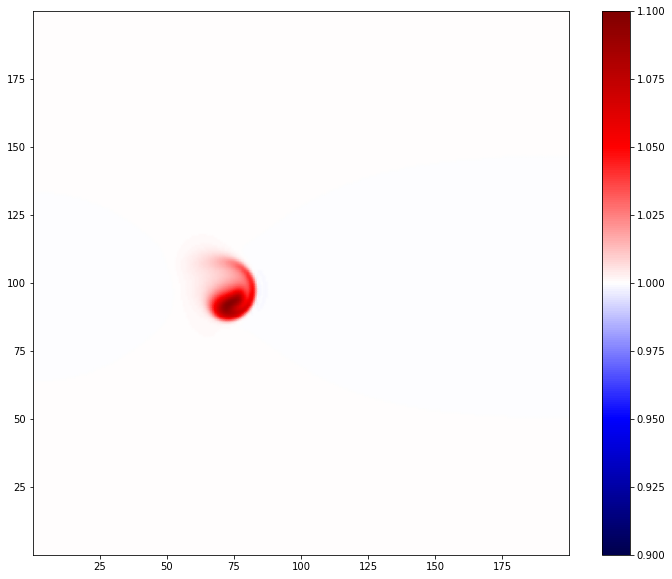

In [13]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
ne = ncin["ne"][:,:,:]

time = ncin["time"][:]
max_idx = np.size( time)-1
plt.figure(figsize=(12, 10))
plt.pcolormesh(xc,yc,ne[max_idx,:,:],
               shading='gouraud',
               cmap = 'seismic', vmin = 0.9, vmax = 1.1 )
plt.colorbar()
#plt.axis('scaled')
plt.show()

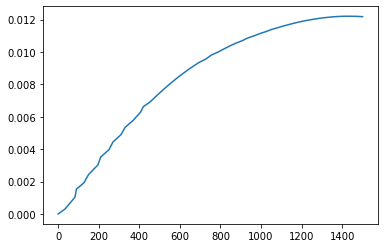

In [14]:
#  plot center of mass velocity
weights= ncin["weights"][:,:]
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
time = ncin["time"][:]
n_e = ncin["ne"][:,:,:]

total_blob_mass = np.sum( (n_e-1)*weights, axis=(1,2) )
com = np.sum( (n_e-1)*xc*weights, axis=(1,2))/total_blob_mass

# Compute foward differences of com to get com velocity

deltat = np.diff(time)
vel = np.diff( com)/deltat
vel = np.append( 0, vel)

# plot
plt.plot( time, vel )


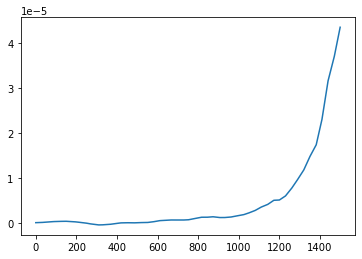

In [16]:
S_e = ncin["Se"][:,:,:]
S_i = ncin["Si"][:,:,:]
U_e = ncin["U"][:,:,:]

total_energy = np.sum( (S_e + S_i + U_e)*weights, axis=(1,2) )

# plot accuracy of energy
plt.plot( time, (total_energy[0]-total_energy)/total_energy[0])